In [1]:
import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

2024-02-06 17:27:29.903751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-02-06 17:27:29.903790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-02-06 17:27:29.903822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

2024-02-06 17:27:29.910330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2024-02-06 17:27:30.610234: W tensorflow/comp

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

print('Original shape of dataset:', train_images.shape)

Original shape of dataset: (60000, 28, 28)


In [3]:
train_images = (train_images - 127.5) / 127.5

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

print('New shape of the dataset:', train_images.shape)

New shape of the dataset: (60000, 28, 28, 1)


Shape of 1 image: (28, 28, 1)


(-0.5, 27.5, 27.5, -0.5)

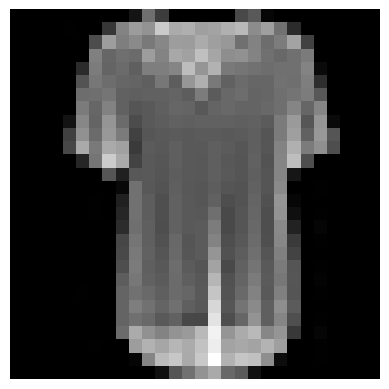

In [5]:
print('Shape of 1 image:', train_images[6969].shape)
plt.imshow(train_images[6969].squeeze(), cmap='gray')
plt.axis('off')

In [6]:
buffer_size = train_images.shape[0]
batch_size = 16

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

2024-02-06 17:27:35.986173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

2024-02-06 17:27:35.987796: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [8]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=100))
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Dense(train_images.shape[1] * train_images.shape[2], activation='tanh'))
    model.add(tf.keras.layers.Reshape(train_images.shape[1:]))

    return model

In [9]:
generator = generator_model()

generator.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 64)                6464      

                                                                 

 re_lu (ReLU)                (None, 64)                0         

                                                                 

 dense_1 (Dense)             (None, 128)               8320      

                                                                 

 re_lu_1 (ReLU)              (None, 128)               0         

                                                                 

 dense_2 (Dense)             (None, 256)               33024     

                                                                 

 re_lu_2 (ReLU)              (None, 256)               0         

                                                                 

 dense_3 (Dense)             (None, 784)

Shape of generated image: (1, 28, 28, 1)


(-0.5, 27.5, 27.5, -0.5)

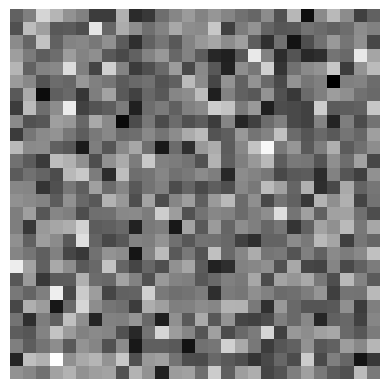

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print('Shape of generated image:', generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray'); plt.axis('off')

In [11]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=train_images.shape[1:]))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [12]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 flatten (Flatten)           (None, 784)               0         

                                                                 

 dense_4 (Dense)             (None, 256)               200960    

                                                                 

 leaky_re_lu (LeakyReLU)     (None, 256)               0         

                                                                 

 dropout (Dropout)           (None, 256)               0         

                                                                 

 dense_5 (Dense)             (None, 128)               32896     

                                                                 

 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         

                                                                 

 dropout_1 (Dropout)         (None, 12

In [13]:
output = discriminator(generated_image)
print('Probability of image to be real:', output)

Probability of image to be real: tf.Tensor([[0.5209325]], shape=(1, 1), dtype=float32)


In [14]:
bce = tf.keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output)

In [20]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (1 + predictions[i, :, :, 0]) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [21]:
def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []

    num_batches = len(dataset)

    for epoch in tqdm(range(epochs)):
        start = time.time()
        
        print(f'Training started with epoch {epoch+1} with {num_batches} batches...')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print(f'Epoch: {epoch+1}\tGenerator loss: {mean_gen_loss}\tDiscriminator loss: {mean_disc_loss}')

        generate_and_plot_images(generator, epoch+1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch+1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec')

    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 3750 batches...


2024-02-06 17:27:36.491336: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch: 1	Generator loss: 2.110231637954712	Discriminator loss: 0.7386881709098816


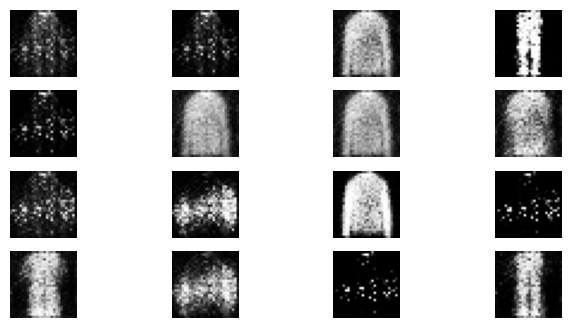

  2%|▏         | 1/50 [00:14<11:57, 14.64s/it]

Time for epoch 1 is 14.6415855884552 sec

Training started with epoch 2 with 3750 batches...

Epoch: 2	Generator loss: 1.3505053520202637	Discriminator loss: 1.0031410455703735


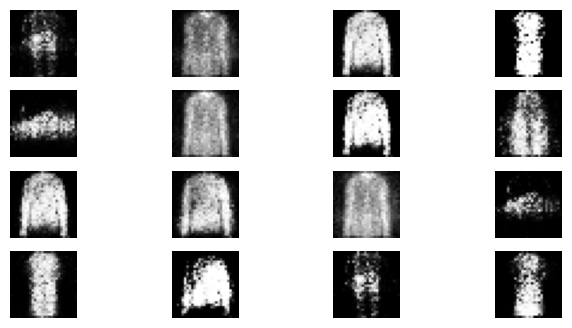

  4%|▍         | 2/50 [00:27<10:46, 13.46s/it]

Time for epoch 2 is 12.636430740356445 sec

Training started with epoch 3 with 3750 batches...

Epoch: 3	Generator loss: 1.0728014707565308	Discriminator loss: 1.1759798526763916


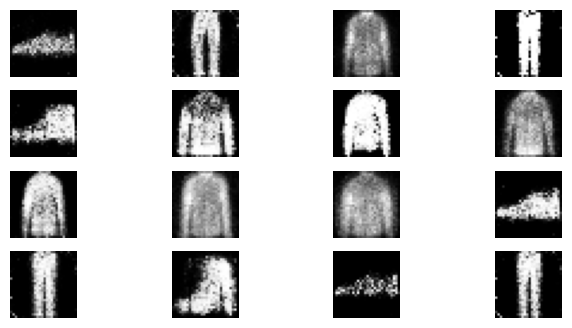

  6%|▌         | 3/50 [00:39<10:03, 12.83s/it]

Time for epoch 3 is 12.086230278015137 sec

Training started with epoch 4 with 3750 batches...

Epoch: 4	Generator loss: 1.016257405281067	Discriminator loss: 1.2148150205612183


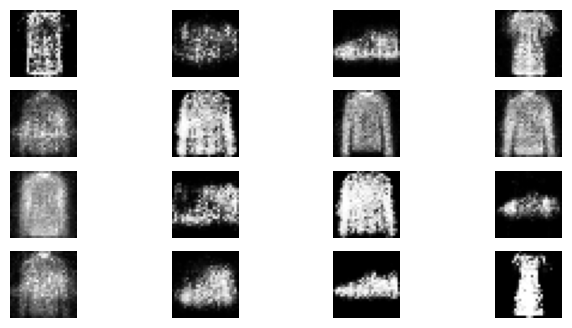

  8%|▊         | 4/50 [00:53<10:19, 13.46s/it]

Time for epoch 4 is 14.41122817993164 sec

Training started with epoch 5 with 3750 batches...

Epoch: 5	Generator loss: 0.9703049063682556	Discriminator loss: 1.24527108669281


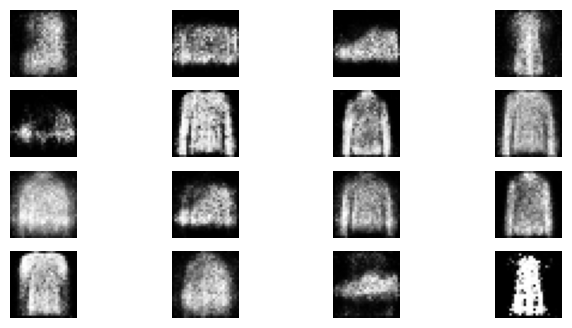

 10%|█         | 5/50 [01:08<10:23, 13.86s/it]

Time for epoch 5 is 14.58349323272705 sec

Training started with epoch 6 with 3750 batches...

Epoch: 6	Generator loss: 0.919076144695282	Discriminator loss: 1.272308111190796


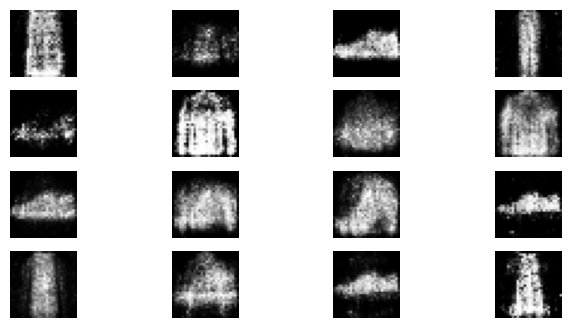

 12%|█▏        | 6/50 [01:22<10:10, 13.88s/it]

Time for epoch 6 is 13.914479970932007 sec

Training started with epoch 7 with 3750 batches...

Epoch: 7	Generator loss: 0.9137119650840759	Discriminator loss: 1.2798434495925903


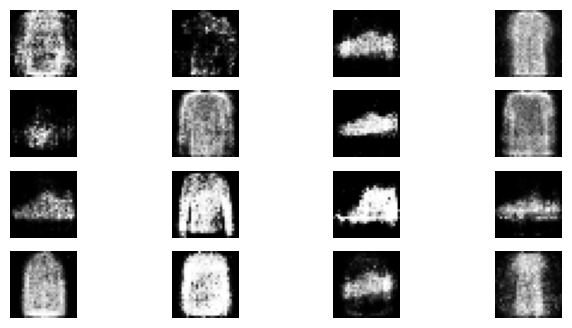

 14%|█▍        | 7/50 [01:34<09:40, 13.50s/it]

Time for epoch 7 is 12.70079255104065 sec

Training started with epoch 8 with 3750 batches...

Epoch: 8	Generator loss: 0.8844090700149536	Discriminator loss: 1.294269323348999


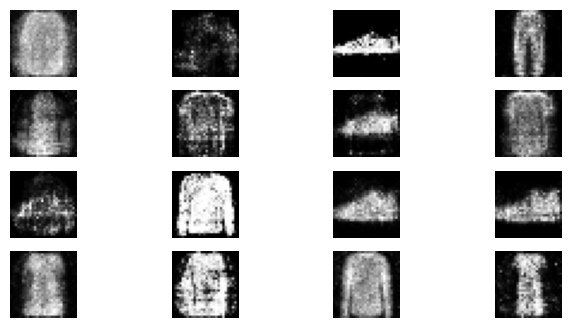

 16%|█▌        | 8/50 [01:46<08:57, 12.79s/it]

Time for epoch 8 is 11.285001516342163 sec

Training started with epoch 9 with 3750 batches...

Epoch: 9	Generator loss: 0.9052576422691345	Discriminator loss: 1.2899876832962036


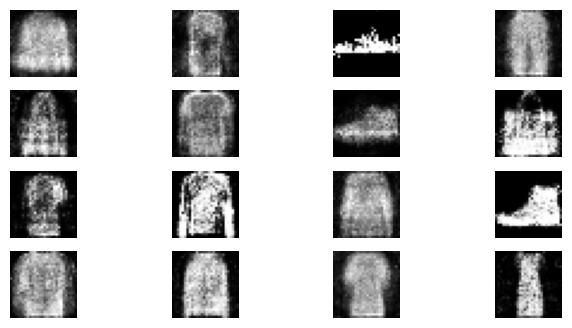

 18%|█▊        | 9/50 [01:58<08:32, 12.50s/it]

Time for epoch 9 is 11.871862888336182 sec

Training started with epoch 10 with 3750 batches...

Epoch: 10	Generator loss: 0.9098668694496155	Discriminator loss: 1.2790782451629639


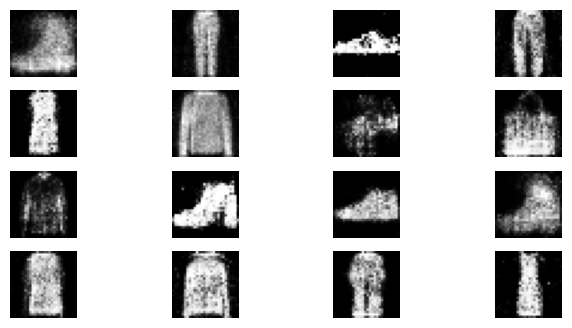

 20%|██        | 10/50 [02:09<08:11, 12.30s/it]

Time for epoch 10 is 11.826874732971191 sec

Training started with epoch 11 with 3750 batches...

Epoch: 11	Generator loss: 0.8894419074058533	Discriminator loss: 1.2894352674484253


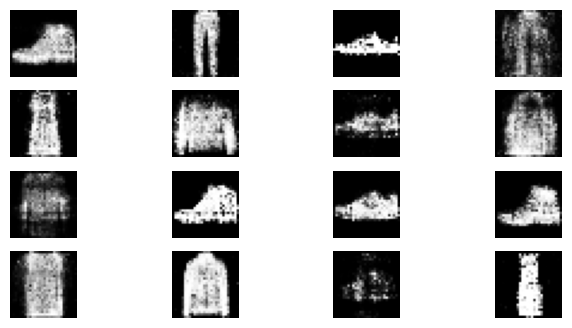

 22%|██▏       | 11/50 [02:21<07:55, 12.19s/it]

Time for epoch 11 is 11.936238288879395 sec

Training started with epoch 12 with 3750 batches...

Epoch: 12	Generator loss: 0.8981672525405884	Discriminator loss: 1.2888212203979492


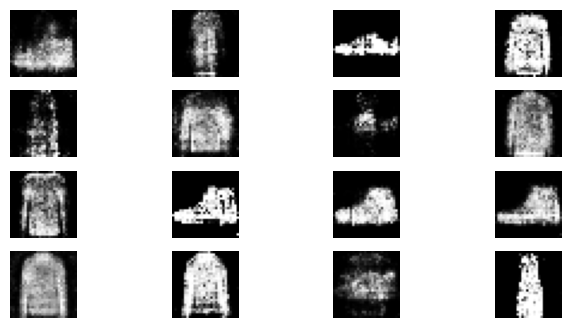

 24%|██▍       | 12/50 [02:34<07:42, 12.17s/it]

Time for epoch 12 is 12.14621615409851 sec

Training started with epoch 13 with 3750 batches...

Epoch: 13	Generator loss: 0.9108678102493286	Discriminator loss: 1.2868506908416748


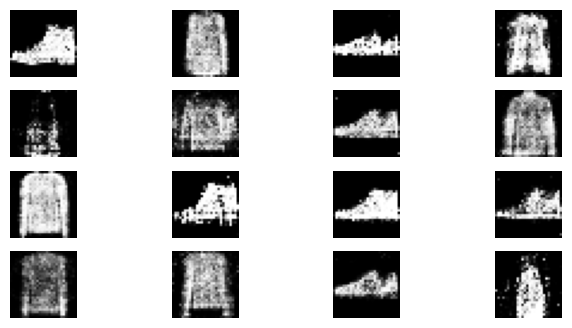

 26%|██▌       | 13/50 [02:47<07:45, 12.59s/it]

Time for epoch 13 is 13.530876159667969 sec

Training started with epoch 14 with 3750 batches...

Epoch: 14	Generator loss: 0.8699858784675598	Discriminator loss: 1.2968038320541382


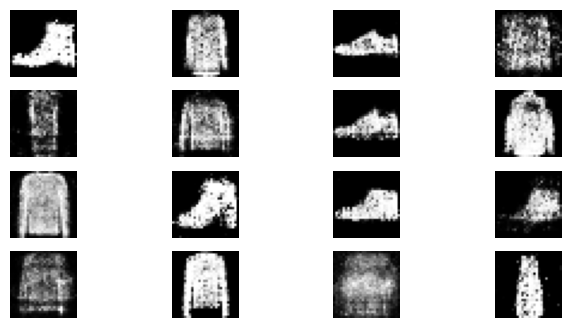

 28%|██▊       | 14/50 [02:59<07:25, 12.39s/it]

Time for epoch 14 is 11.927879095077515 sec

Training started with epoch 15 with 3750 batches...

Epoch: 15	Generator loss: 0.881498396396637	Discriminator loss: 1.3032644987106323


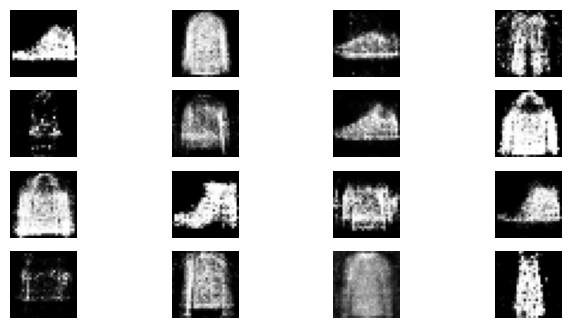

 30%|███       | 15/50 [03:12<07:18, 12.51s/it]

Time for epoch 15 is 12.810293674468994 sec

Training started with epoch 16 with 3750 batches...

Epoch: 16	Generator loss: 0.8561244010925293	Discriminator loss: 1.306988000869751


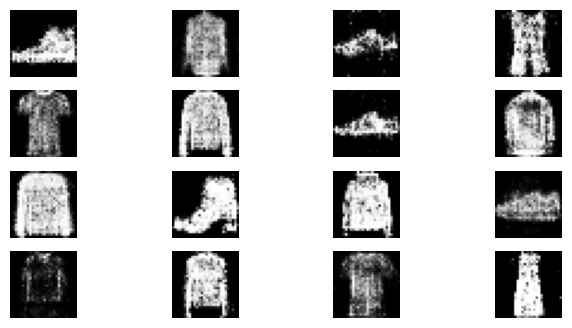

 32%|███▏      | 16/50 [03:24<07:04, 12.50s/it]

Time for epoch 16 is 12.463695049285889 sec

Training started with epoch 17 with 3750 batches...

Epoch: 17	Generator loss: 0.8798385262489319	Discriminator loss: 1.3059196472167969


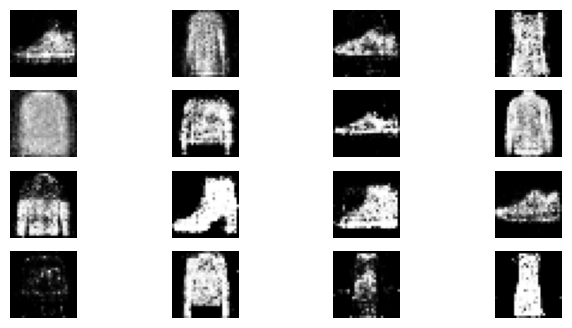

 34%|███▍      | 17/50 [03:37<06:59, 12.70s/it]

Time for epoch 17 is 13.17876124382019 sec

Training started with epoch 18 with 3750 batches...

Epoch: 18	Generator loss: 0.8443259596824646	Discriminator loss: 1.315259337425232


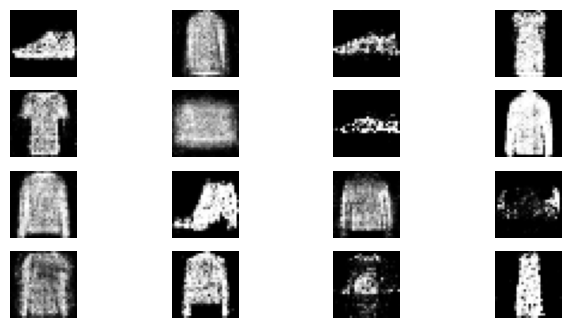

 36%|███▌      | 18/50 [03:49<06:39, 12.48s/it]

Time for epoch 18 is 11.951339960098267 sec

Training started with epoch 19 with 3750 batches...

Epoch: 19	Generator loss: 0.8834221959114075	Discriminator loss: 1.3009082078933716


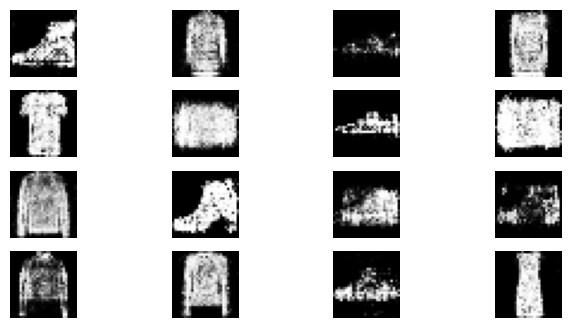

 38%|███▊      | 19/50 [04:01<06:21, 12.32s/it]

Time for epoch 19 is 11.947330713272095 sec

Training started with epoch 20 with 3750 batches...

Epoch: 20	Generator loss: 0.8578821420669556	Discriminator loss: 1.3145036697387695


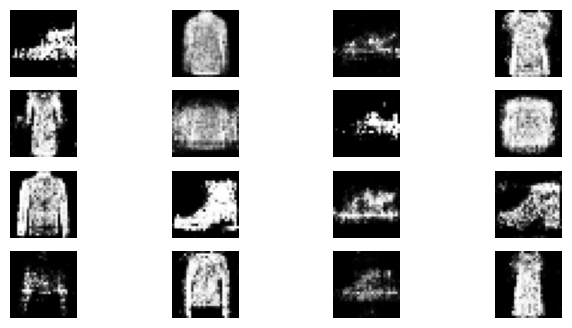

 40%|████      | 20/50 [04:14<06:08, 12.28s/it]

Time for epoch 20 is 12.179637432098389 sec

Training started with epoch 21 with 3750 batches...

Epoch: 21	Generator loss: 0.8740420937538147	Discriminator loss: 1.30557119846344


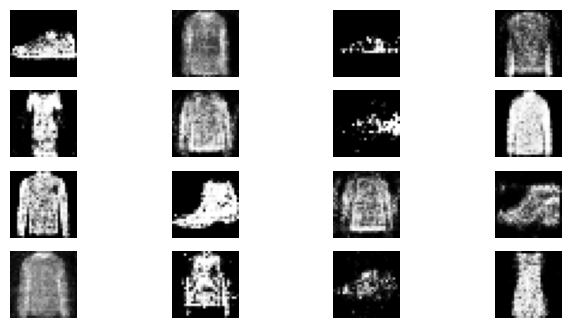

 42%|████▏     | 21/50 [04:26<05:56, 12.30s/it]

Time for epoch 21 is 12.359360218048096 sec

Training started with epoch 22 with 3750 batches...

Epoch: 22	Generator loss: 0.8590276837348938	Discriminator loss: 1.313316822052002


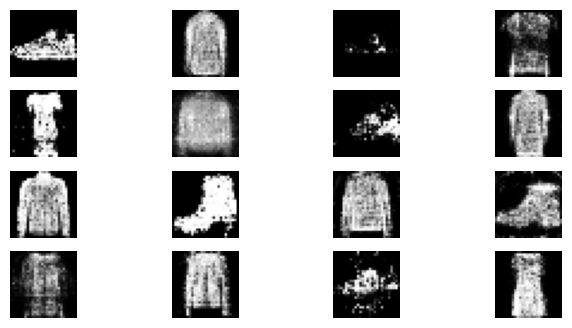

 44%|████▍     | 22/50 [04:39<05:51, 12.56s/it]

Time for epoch 22 is 13.149548530578613 sec

Training started with epoch 23 with 3750 batches...

Epoch: 23	Generator loss: 0.8554722666740417	Discriminator loss: 1.3146671056747437


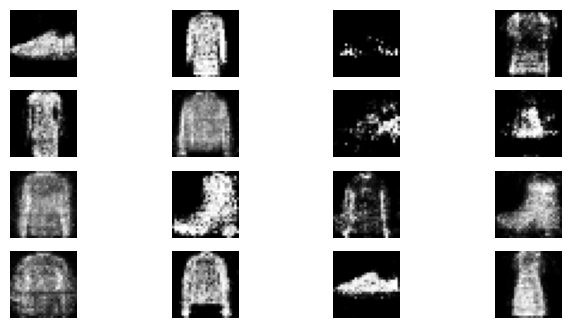

 46%|████▌     | 23/50 [04:52<05:38, 12.55s/it]

Time for epoch 23 is 12.540950775146484 sec

Training started with epoch 24 with 3750 batches...

Epoch: 24	Generator loss: 0.8383995294570923	Discriminator loss: 1.318974256515503


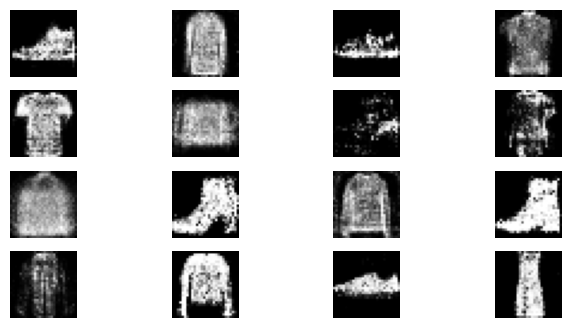

 48%|████▊     | 24/50 [05:04<05:24, 12.50s/it]

Time for epoch 24 is 12.373802661895752 sec

Training started with epoch 25 with 3750 batches...

Epoch: 25	Generator loss: 0.8307672142982483	Discriminator loss: 1.3277400732040405


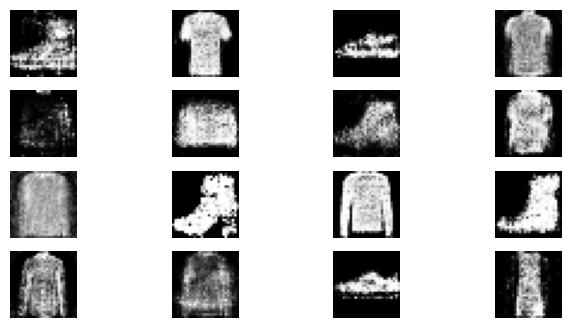

 50%|█████     | 25/50 [05:17<05:12, 12.51s/it]

Time for epoch 25 is 12.536082029342651 sec

Training started with epoch 26 with 3750 batches...

Epoch: 26	Generator loss: 0.8486964702606201	Discriminator loss: 1.3203438520431519


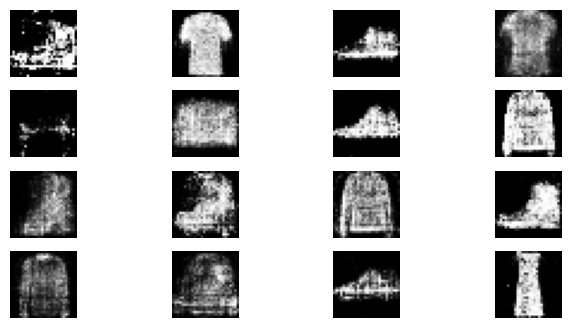

 52%|█████▏    | 26/50 [05:29<04:58, 12.45s/it]

Time for epoch 26 is 12.32339596748352 sec

Training started with epoch 27 with 3750 batches...

Epoch: 27	Generator loss: 0.8344686031341553	Discriminator loss: 1.3251664638519287


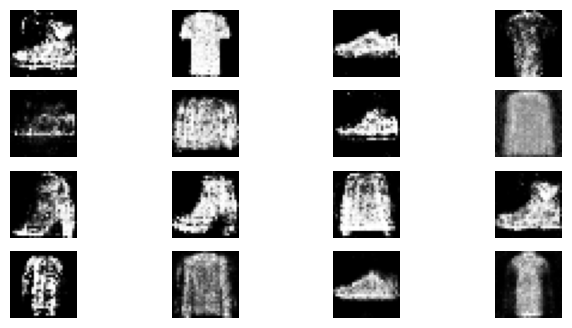

 54%|█████▍    | 27/50 [05:41<04:46, 12.47s/it]

Time for epoch 27 is 12.520482540130615 sec

Training started with epoch 28 with 3750 batches...

Epoch: 28	Generator loss: 0.8320975303649902	Discriminator loss: 1.3254977464675903


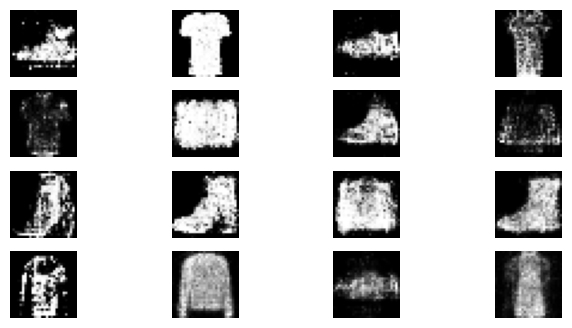

 56%|█████▌    | 28/50 [05:54<04:34, 12.46s/it]

Time for epoch 28 is 12.432697296142578 sec

Training started with epoch 29 with 3750 batches...

Epoch: 29	Generator loss: 0.8026244640350342	Discriminator loss: 1.337796926498413


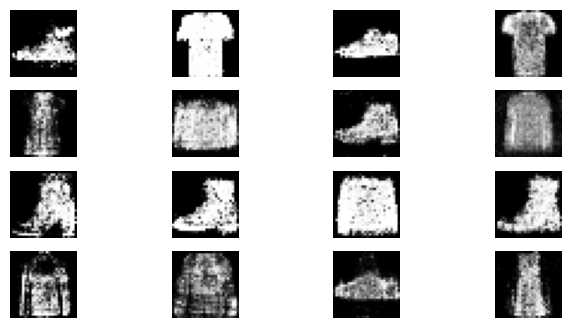

 58%|█████▊    | 29/50 [06:07<04:23, 12.54s/it]

Time for epoch 29 is 12.72927975654602 sec

Training started with epoch 30 with 3750 batches...

Epoch: 30	Generator loss: 0.8287801146507263	Discriminator loss: 1.3341455459594727


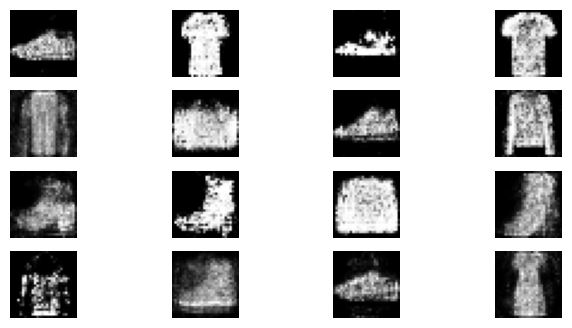

 60%|██████    | 30/50 [06:19<04:10, 12.55s/it]

Time for epoch 30 is 12.552963495254517 sec

Training started with epoch 31 with 3750 batches...

Epoch: 31	Generator loss: 0.8305041193962097	Discriminator loss: 1.327081322669983


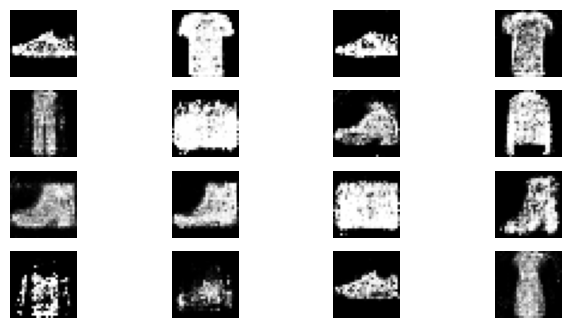

 62%|██████▏   | 31/50 [06:32<03:57, 12.52s/it]

Time for epoch 31 is 12.459290266036987 sec

Training started with epoch 32 with 3750 batches...

Epoch: 32	Generator loss: 0.8110506534576416	Discriminator loss: 1.336747169494629


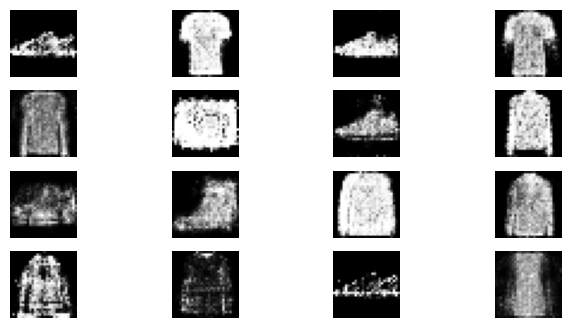

 64%|██████▍   | 32/50 [06:44<03:46, 12.61s/it]

Time for epoch 32 is 12.81147837638855 sec

Training started with epoch 33 with 3750 batches...

Epoch: 33	Generator loss: 0.8094066381454468	Discriminator loss: 1.3391660451889038


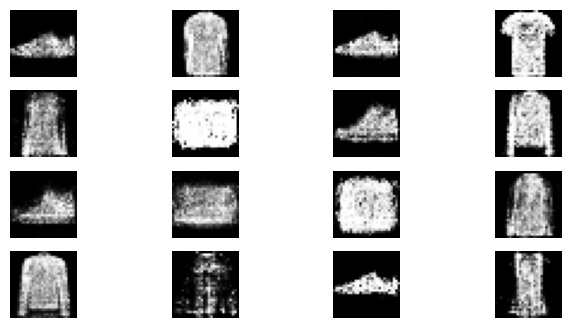

 66%|██████▌   | 33/50 [06:56<03:31, 12.45s/it]

Time for epoch 33 is 12.084664583206177 sec

Training started with epoch 34 with 3750 batches...

Epoch: 34	Generator loss: 0.8021955490112305	Discriminator loss: 1.3379552364349365


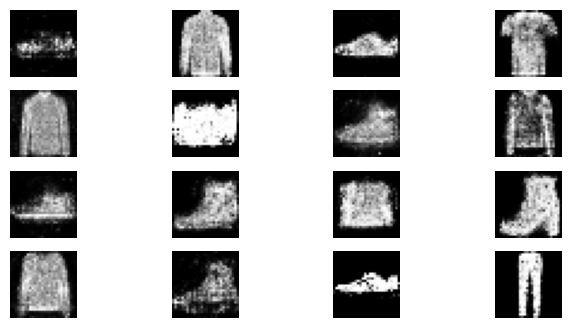

 68%|██████▊   | 34/50 [07:10<03:22, 12.64s/it]

Time for epoch 34 is 13.096752166748047 sec

Training started with epoch 35 with 3750 batches...

Epoch: 35	Generator loss: 0.7914963364601135	Discriminator loss: 1.343112587928772


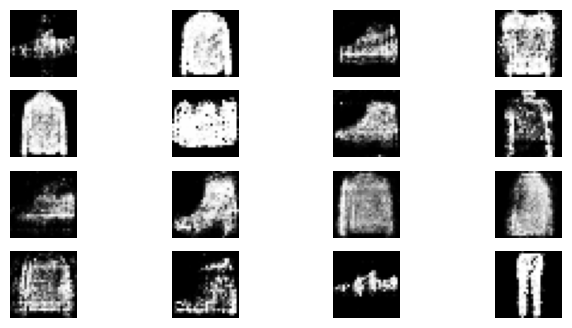

 70%|███████   | 35/50 [07:23<03:11, 12.77s/it]

Time for epoch 35 is 13.072559356689453 sec

Training started with epoch 36 with 3750 batches...

Epoch: 36	Generator loss: 0.8203344941139221	Discriminator loss: 1.337041974067688


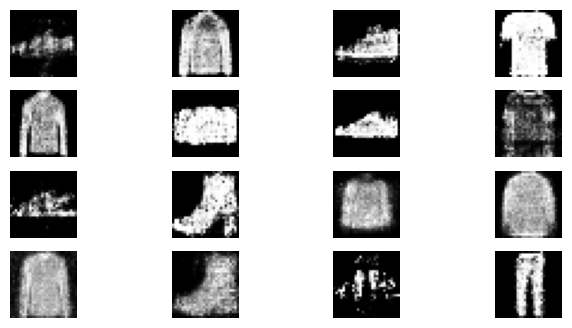

 72%|███████▏  | 36/50 [07:36<02:59, 12.84s/it]

Time for epoch 36 is 13.010035037994385 sec

Training started with epoch 37 with 3750 batches...

Epoch: 37	Generator loss: 0.783219575881958	Discriminator loss: 1.343919277191162


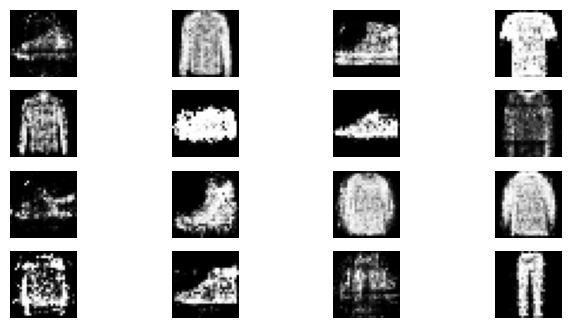

 74%|███████▍  | 37/50 [07:49<02:49, 13.03s/it]

Time for epoch 37 is 13.459967851638794 sec

Training started with epoch 38 with 3750 batches...

Epoch: 38	Generator loss: 0.7839194536209106	Discriminator loss: 1.3478986024856567


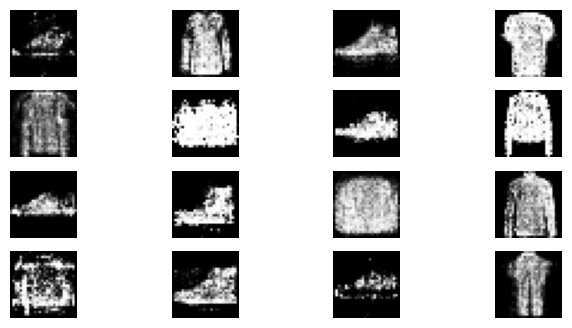

 76%|███████▌  | 38/50 [08:02<02:36, 13.03s/it]

Time for epoch 38 is 13.042091369628906 sec

Training started with epoch 39 with 3750 batches...

Epoch: 39	Generator loss: 0.7760099768638611	Discriminator loss: 1.3521424531936646


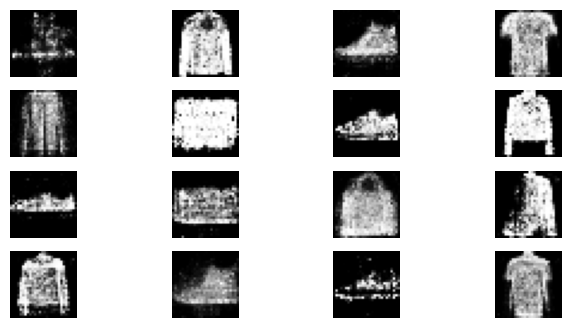

 78%|███████▊  | 39/50 [08:17<02:28, 13.53s/it]

Time for epoch 39 is 14.701199054718018 sec

Training started with epoch 40 with 3750 batches...

Epoch: 40	Generator loss: 0.804787278175354	Discriminator loss: 1.3449997901916504


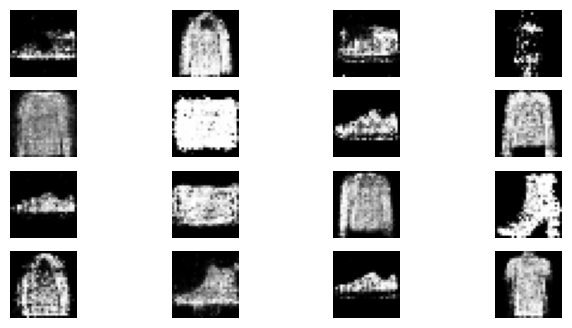

 80%|████████  | 40/50 [08:31<02:16, 13.61s/it]

Time for epoch 40 is 13.777672529220581 sec

Training started with epoch 41 with 3750 batches...

Epoch: 41	Generator loss: 0.792234480381012	Discriminator loss: 1.3455700874328613


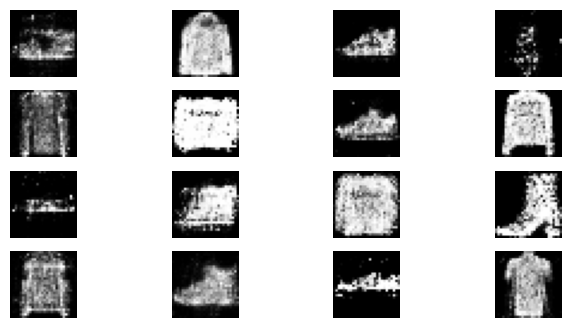

 82%|████████▏ | 41/50 [08:44<02:01, 13.45s/it]

Time for epoch 41 is 13.099032402038574 sec

Training started with epoch 42 with 3750 batches...

Epoch: 42	Generator loss: 0.7671225070953369	Discriminator loss: 1.3558762073516846


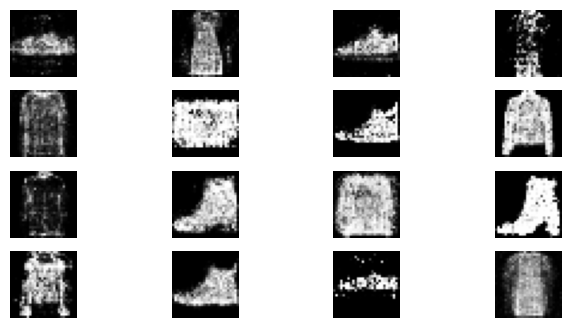

 84%|████████▍ | 42/50 [08:57<01:47, 13.44s/it]

Time for epoch 42 is 13.393343448638916 sec

Training started with epoch 43 with 3750 batches...

Epoch: 43	Generator loss: 0.7624651193618774	Discriminator loss: 1.358876347541809


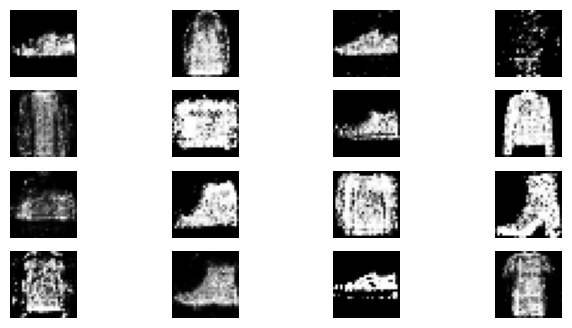

 86%|████████▌ | 43/50 [09:11<01:35, 13.70s/it]

Time for epoch 43 is 14.300349473953247 sec

Training started with epoch 44 with 3750 batches...

Epoch: 44	Generator loss: 0.7536097764968872	Discriminator loss: 1.3645355701446533


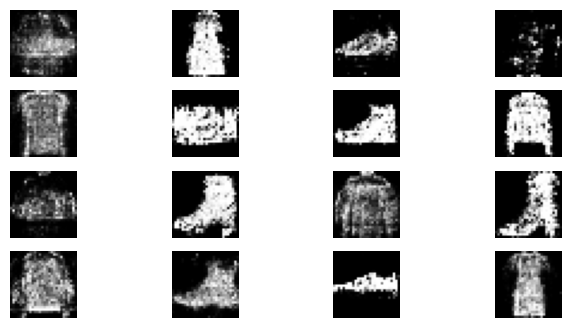

 88%|████████▊ | 44/50 [09:25<01:22, 13.76s/it]

Time for epoch 44 is 13.894305944442749 sec

Training started with epoch 45 with 3750 batches...

Epoch: 45	Generator loss: 0.756318211555481	Discriminator loss: 1.3636908531188965


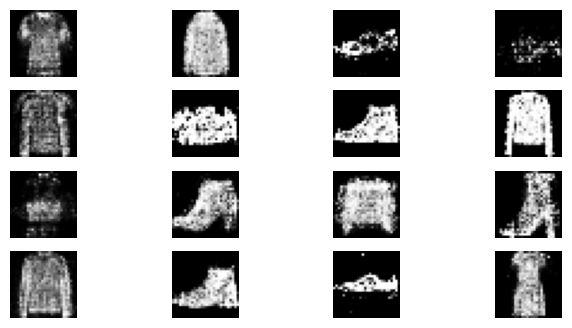

 90%|█████████ | 45/50 [09:39<01:08, 13.62s/it]

Time for epoch 45 is 13.298742771148682 sec

Training started with epoch 46 with 3750 batches...

Epoch: 46	Generator loss: 0.7648112773895264	Discriminator loss: 1.3599551916122437


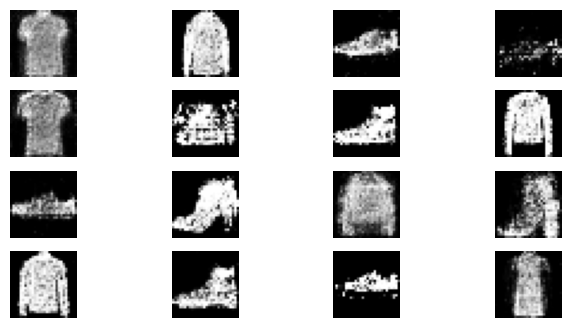

 92%|█████████▏| 46/50 [09:53<00:55, 13.88s/it]

Time for epoch 46 is 14.47902250289917 sec

Training started with epoch 47 with 3750 batches...

Epoch: 47	Generator loss: 0.7797093987464905	Discriminator loss: 1.3534855842590332


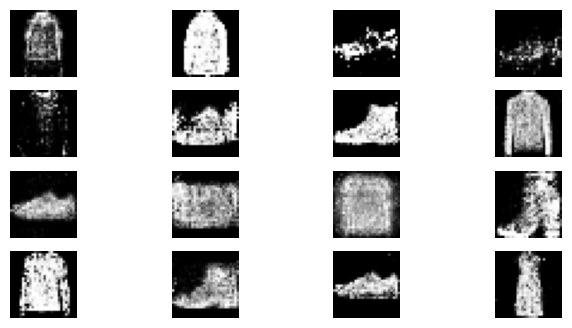

 94%|█████████▍| 47/50 [10:06<00:41, 13.72s/it]

Time for epoch 47 is 13.338077545166016 sec

Training started with epoch 48 with 3750 batches...

Epoch: 48	Generator loss: 0.7580714821815491	Discriminator loss: 1.3606480360031128


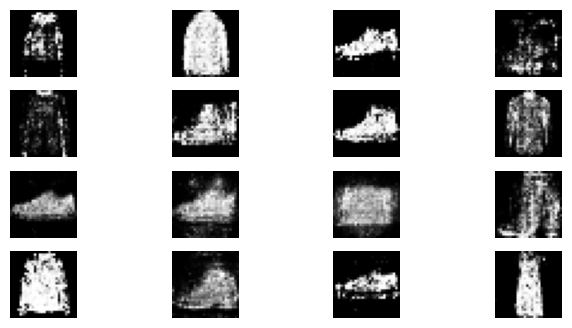

 96%|█████████▌| 48/50 [10:21<00:28, 14.10s/it]

Time for epoch 48 is 14.993326187133789 sec

Training started with epoch 49 with 3750 batches...

Epoch: 49	Generator loss: 0.7546244859695435	Discriminator loss: 1.3633815050125122


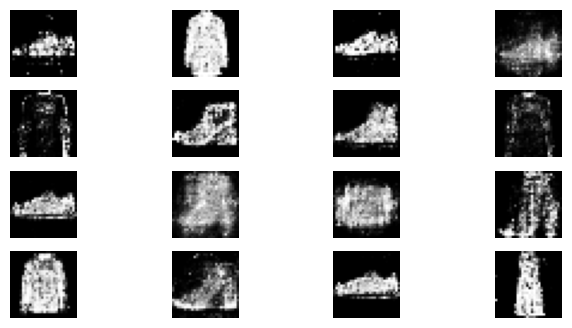

 98%|█████████▊| 49/50 [10:34<00:13, 13.66s/it]

Time for epoch 49 is 12.630540370941162 sec

Training started with epoch 50 with 3750 batches...

Epoch: 50	Generator loss: 0.7450929880142212	Discriminator loss: 1.3711183071136475


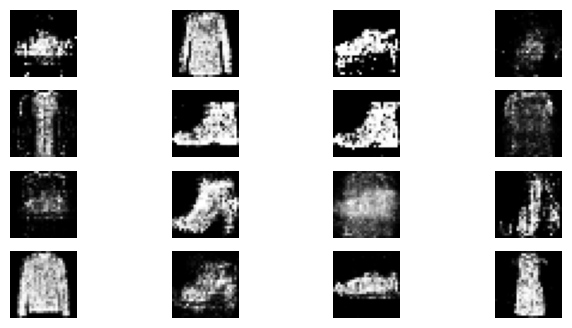

100%|██████████| 50/50 [10:49<00:00, 12.98s/it]

Time for epoch 50 is 14.505173206329346 sec


In [22]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs)

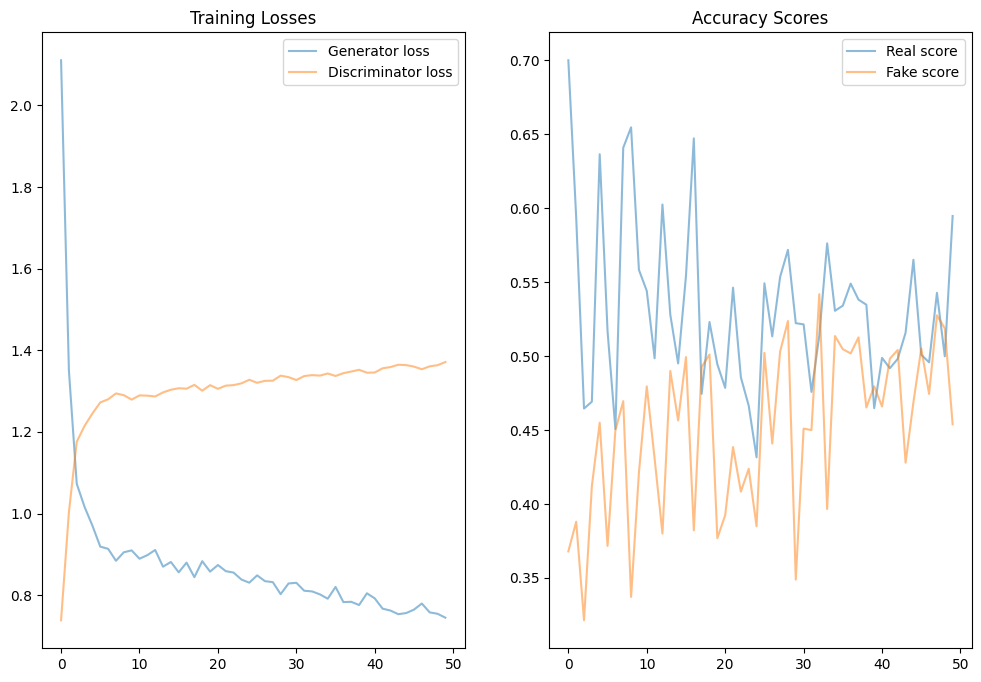

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')
ax2.legend()